In [1]:
import time
import nrrd
import nibabel as nb
import numpy as np
import matplotlib.pyplot as plt
import h5py

from dipy.tracking.local import LocalTracking, ThresholdTissueClassifier
from dipy.tracking.utils import random_seeds_from_mask
from dipy.reconst.dti import TensorModel
from dipy.reconst.csdeconv import (ConstrainedSphericalDeconvModel,
                                   auto_response)
from dipy.reconst.shm import CsaOdfModel
from dipy.data import default_sphere
from dipy.direction import peaks_from_model
from dipy.data import fetch_stanford_hardi, read_stanford_hardi, get_sphere
from dipy.segment.mask import median_otsu
from dipy.viz import actor, window
from dipy.io.image import save_nifti
from dipy.io import read_bvals_bvecs
from dipy.core import gradients
from dipy.tracking.streamline import Streamlines
from dipy.io import read_bvals_bvecs
from dipy.core.gradients import gradient_table, gradient_table_from_bvals_bvecs
from dipy.reconst.dti import fractional_anisotropy

from dipy.tracking import utils

import src.dwi_tools as dwi_tools
import src.nn_helper as nn_helper

Using TensorFlow backend.


In [2]:
pTrainData_fibrePrediction = 'train_prediction_grid_normalized_dti_cs1_wholebrain.h5'
pTrainData_fibreTracking = 'train_tracking_grid_normalized_dti_cs1_wholebrain.h5'
pTrainInput = 'train_input_normalized_dti_cs1_wholebrain_'
noCrossings = 3

# Data Handling

load bvec/bval and compute gradient table

In [3]:
bvals, bvecs = read_bvals_bvecs('100307/bvals', '100307/bvecs')
gtab = gradient_table(bvals=bvals, bvecs=bvecs,b0_threshold=5)

In [4]:
img = nb.load('100307/data.nii.gz')
dwi = img.get_data()
aff = img.affine
img = nb.load('100307/T1w_acpc_dc_restore_1.25.nii.gz')
t1 = img.get_data()
binarymask, options = nrrd.read('100307/nodif_brain_mask.nrrd')

In [5]:
aff = np.eye(4,4)

visualize DWI data

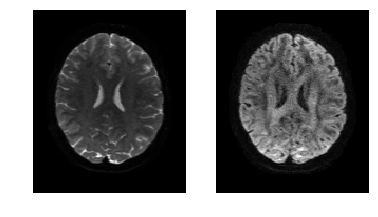

In [6]:
axial_middle = dwi.shape[2] // 2
plt.figure('Showing the datasets')
plt.subplot(1, 2, 1).set_axis_off()
plt.imshow(dwi[:, :, axial_middle, 0].T, cmap='gray', origin='lower')
plt.subplot(1, 2, 2).set_axis_off()
plt.imshow(dwi[:, :, axial_middle, 10].T, cmap='gray', origin='lower')
plt.show()

# Tractography

In this section we'll generate streamlines using different approaches. This is gonna be the foundation for the evaluation of our method. We'll also employ simulated as well as curated data for our analysis.

In [7]:
# roi_idx = (slice(20, 50), slice(55, 85), slice(38, 39)) #  splenium of the corpus callosum
from dipy.tracking.utils import random_seeds_from_mask, seeds_from_mask
ccmask = np.zeros(binarymask.shape)
ccmask[20:50,55:85,38:39] = 1

In [8]:
ccseeds = seeds_from_mask(ccmask)

In [9]:
ccmask, options = nrrd.read('100307/100307-ccSegmentation.nrrd')
ccseeds = seeds_from_mask(ccmask, affine=aff)
ccseedsNoAffine = seeds_from_mask(ccmask)

Slicer/UKF Data

## Diffusion Tensor Imaging

compute fractional anisotropy and select seeds_count seeds per voxel with FA > 0.3

In [16]:
import dipy.reconst.dti as dti
start_time = time.time()
dti_wls = dti.TensorModel(gtab)
fit_wls = dti_wls.fit(dwi)
FA = fit_wls.fa
runtime = time.time() - start_time
print('Runtime ' + str(runtime) + 's')
#seeds = random_seeds_from_mask(FA > 0.5, seeds_count=1)

Runtime 788.6898355484009s


In [17]:
sphere = get_sphere('symmetric724')
start_time = time.time()
dtipeaks = peaks_from_model(model=dti_wls,
                            data=dwi,
                            sphere=sphere,
                            relative_peak_threshold=.5,
                            min_separation_angle=25,
                            mask=binarymask,
                            return_odf=False,
                            parallel=True,
                            normalize_peaks=False,
                            nbr_processes=48
                           )
runtime = time.time() - start_time
print('Runtime ' + str(runtime) + 's')

Runtime 968.2854478359222s


In [18]:
validationSeeds = ccseeds[45:48]
len(validationSeeds)

3

In [19]:
validationSeeds

array([[70., 73., 62.],
       [70., 73., 63.],
       [70., 73., 64.]])

In [20]:
classifier = ThresholdTissueClassifier(dtipeaks.gfa, .25)
streamlines_generator = LocalTracking(dtipeaks, classifier, ccseeds, np.identity(4), step_size=.1)
#streamlines_generator = LocalTracking(dtipeaks, classifier, ccseeds, aff, step_size=.1)
streamlines = Streamlines(streamlines_generator)
streamlines_filtered = dwi_tools.filterStreamlinesByLength(streamlines, 50)

In [ ]:
dwi_tools.visStreamlines(streamlines,t1,vol_slice_idx=40)
#dwi_tools.visStreamlines(streamlines_filtered,t1,vol_slice_idx=76)

## Q-ball Reconstruction

In [ ]:
csamodel = CsaOdfModel(gtab, 4)
sphere = get_sphere('symmetric724')
start_time = time.time()
csapeaks = peaks_from_model(model=csamodel,
                            data=dwi,
                            sphere=sphere,
                            relative_peak_threshold=.5,
                            min_separation_angle=25,
                            mask=binarymask,
                            return_odf=False,
                            parallel=True,
                            normalize_peaks=False)

GFA = csapeaks.gfa
runtime = time.time() - start_time
print('Runtime ' + str(runtime) + ' s / GFA.shape (%d, %d, %d)' % GFA.shape)

tracking

In [ ]:
classifier = ThresholdTissueClassifier(dtipeaks.gfa, .25)
streamlines_generator = LocalTracking(csapeaks, classifier, seeds, np.identity(4), step_size=.5)
streamlines = Streamlines(streamlines_generator)
streamlines_filtered = dwi_tools.filterStreamlinesByLength(streamlines, 50)

Visualisation

In [ ]:
dwi_tools.visStreamlines(streamlines,t1)
#dwi_tools.visStreamlines(streamlines_filtered,t1,vol_slice_idx=76)

## Constrained Spherical Deconvolution

Use in case of b = 2,500 – 3,000 s/mm² data

In [ ]:
response, ratio = auto_response(gtab, dwi, roi_radius=10, fa_thr=0.5)
print(response)
print(ratio)
csd_model = ConstrainedSphericalDeconvModel(gtab, response)
sphere = get_sphere('symmetric724')
start_time = time.time()
csd_peaks = peaks_from_model(model=csd_model,
                             data=dwi,
                             sphere=sphere,
                             mask=binarymask,
                             relative_peak_threshold=.5,
                             min_separation_angle=25,
                             parallel=True)
GFA = csd_peaks.gfa
runtime = time.time() - start_time
print('Runtime ' + str(runtime) + ' s / GFA.shape (%d, %d, %d)' % GFA.shape)

In [ ]:
classifier = ThresholdTissueClassifier(csd_peaks.gfa, .25)
streamlines_generator = LocalTracking(csd_peaks, classifier, ccseeds, np.identity(4), step_size=.5)
streamlines = Streamlines(streamlines_generator)
streamlines_filtered = dwi_tools.filterStreamlinesByLength(streamlines, 50)

Visualisation

In [ ]:
dwi_tools.visStreamlines(streamlines_filtered,t1)

### Store intermediate data

In [25]:
np.save(pTrainInput + "_sl_filt.npy",streamlines_filtered)
np.save(pTrainInput + "_sl.npy",streamlines)
np.save(pTrainInput + "_seeds.npy",ccseeds)

# Generate Training data

prepare training data for fibre direction network

In [156]:
avB0 = np.mean(dwi[:, :, :, gtab.b0s_mask])

In [159]:
dwi_B0normalized = dwi / avB0 # normalize data.. typically averaging would be used however that would yield dwi values way above 1 (6.5)
dwi_B0normalized = dwi_B0normalized[:, :, :, ~gtab.b0s_mask]  # remove B0 scans from dataset

In [162]:
noX = 8
noY = 8
noZ = 8
coordinateScaling = 1

In [163]:
import importlib
importlib.reload(dwi_tools)
#streamlines_filtered = np.asarray(np.load(pTrainInput + "_sl_filt.npy"))
#np.random.shuffle(streamlines_filtered)
import src.dwi_tools as dwi_tools
import src.nn_helper as nn_helper
start_time = time.time()
train_DWI,train_prevDirection, train_LikelyFibreDirections, train_NextDirection = dwi_tools.generatePredictionNetworkTrainingDataFromStreamlines(streamlines_filtered, dwi_B0normalized, noX=noX,noY=noY,noZ=noZ,coordinateScaling=coordinateScaling,distToNeighbours=1, noCrossings = noCrossings)
runtime = time.time() - start_time
print('Runtime ' + str(runtime) + ' s ')

Generating training data
using [8, 8, 8]px interpolation grid with coordinateScaling 1
0/72027


/home/nico/Code/deepFibreTracking/src/dwi_tools.py:219: RuntimeWarning: invalid value encountered in true_divide
  train_X_2[ctr,] = streamlinevec_prev - streamlinevec


1000/72027
2000/72027
3000/72027
4000/72027
5000/72027
6000/72027
7000/72027
8000/72027
9000/72027
10000/72027
11000/72027
12000/72027
13000/72027
14000/72027
15000/72027
16000/72027
17000/72027
18000/72027
19000/72027
20000/72027
21000/72027
22000/72027
23000/72027
24000/72027
25000/72027
26000/72027
27000/72027
28000/72027
29000/72027
30000/72027
31000/72027
32000/72027
33000/72027
34000/72027
35000/72027
36000/72027
37000/72027
38000/72027
39000/72027
40000/72027
41000/72027
42000/72027
43000/72027
44000/72027
45000/72027
46000/72027
47000/72027
48000/72027
49000/72027
50000/72027
51000/72027
52000/72027
53000/72027
54000/72027
55000/72027
56000/72027
57000/72027
58000/72027
59000/72027
60000/72027
61000/72027
62000/72027
63000/72027
64000/72027
65000/72027
66000/72027
67000/72027
68000/72027
69000/72027
70000/72027
71000/72027
72000/72027
Runtime 1217.4243984222412 s 


/home/nico/Code/deepFibreTracking/src/dwi_tools.py:217: RuntimeWarning: invalid value encountered in true_divide
  train_Y_2[ctr,] = streamlinevec_next - streamlinevec


In [164]:
with h5py.File(pTrainData_fibrePrediction+'norm',"w") as f:
    f.create_dataset('train_DWI',data=train_DWI)
    f.create_dataset('train_curPosition',data=train_prevDirection)   
    f.create_dataset('train_LikelyFibreDirections',data=train_LikelyFibreDirections)   
    f.create_dataset('train_NextFibreDirection',data=train_NextDirection)   

## Training

In [165]:
noGPUs = 3
batch_size = 2**8
batch_size -= batch_size % noGPUs # make batch size divisible by no. of GPUs
epochs = 50

In [171]:
f = h5py.File(pTrainData_fibrePrediction, "r")
train_DWI = np.array(f["train_DWI"].value)
train_prevDirection = np.array(f["train_curPosition"].value)
train_likelyDirections = np.array(f["train_LikelyFibreDirections"].value)
train_nextDirection = np.array(f["train_NextFibreDirection"].value)
f.close()
#train_lastDirection = np.expand_dims(train_lastDirection, axis=1)

MemoryError: 

### data normalization

In [ ]:
#train_LikelyFibreDirections = (train_LikelyFibreDirections + 1) / 2
#train_lastDirection = (train_lastDirection + 1) / 2
#train_DWI = nn_helper.normalizeDWI(train_DWI)
##train_lastDirection_unit = nn_helper.normalizeStreamlineOrientation(train_lastDirection)
##train_NextFibreDirection_unit = nn_helper.normalizeStreamlineOrientation(train_NextFibreDirection)

## MLP

simple

In [191]:
from keras.layers.advanced_activations import LeakyReLU
from keras.layers import Activation
import importlib
importlib.reload(nn_helper)
from keras.callbacks import TensorBoard
mlp_simple_newNormalisation = nn_helper.get_mlp_simpleTracker(activation_function = LeakyReLU(), features = 512, inputShapeDWI=(noX, noY, noZ, 270),depth = 3, noGPUs=noGPUs)
mlp_simple_newNormalisation.fit([train_DWI], [train_prevDirection,train_nextDirection], batch_size=batch_size, epochs=10, verbose=1,validation_split=0.2, callbacks=[])

Train on 57621 samples, validate on 14406 samples
Epoch 1/10


ResourceExhaustedError: OOM when allocating tensor with shape[1] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: training_12/Adam/Variable_25/Assign = Assign[T=DT_FLOAT, _grappler_relax_allocator_constraints=true, use_locking=true, validate_shape=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](training_12/Adam/Variable_25, training_12/Adam/zeros_20)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


Caused by op 'training_12/Adam/Variable_25/Assign', defined at:
  File "/home/nico/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/nico/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/nico/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/nico/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/nico/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/home/nico/anaconda3/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 127, in start
    self.asyncio_loop.run_forever()
  File "/home/nico/anaconda3/lib/python3.6/asyncio/base_events.py", line 422, in run_forever
    self._run_once()
  File "/home/nico/anaconda3/lib/python3.6/asyncio/base_events.py", line 1432, in _run_once
    handle._run()
  File "/home/nico/anaconda3/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/home/nico/anaconda3/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 117, in _handle_events
    handler_func(fileobj, events)
  File "/home/nico/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/nico/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/home/nico/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/nico/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/home/nico/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/nico/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/nico/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/nico/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/nico/anaconda3/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/nico/anaconda3/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/nico/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/nico/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/nico/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2909, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/nico/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-191-a1ea062e1072>", line 7, in <module>
    mlp_simple_newNormalisation.fit([train_DWI], [train_prevDirection,train_nextDirection], batch_size=batch_size, epochs=10, verbose=1,validation_split=0.2, callbacks=[])
  File "/home/nico/anaconda3/lib/python3.6/site-packages/keras/engine/training.py", line 1008, in fit
    self._make_train_function()
  File "/home/nico/anaconda3/lib/python3.6/site-packages/keras/engine/training.py", line 498, in _make_train_function
    loss=self.total_loss)
  File "/home/nico/anaconda3/lib/python3.6/site-packages/keras/legacy/interfaces.py", line 91, in wrapper
    return func(*args, **kwargs)
  File "/home/nico/anaconda3/lib/python3.6/site-packages/keras/optimizers.py", line 487, in get_updates
    vhats = [K.zeros(1) for _ in params]
  File "/home/nico/anaconda3/lib/python3.6/site-packages/keras/optimizers.py", line 487, in <listcomp>
    vhats = [K.zeros(1) for _ in params]
  File "/home/nico/anaconda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py", line 702, in zeros
    return variable(v, dtype=dtype, name=name)
  File "/home/nico/anaconda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py", line 400, in variable
    v = tf.Variable(value, dtype=tf.as_dtype(dtype), name=name)
  File "/home/nico/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/variables.py", line 259, in __init__
    constraint=constraint)
  File "/home/nico/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/variables.py", line 412, in _init_from_args
    validate_shape=validate_shape).op
  File "/home/nico/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/state_ops.py", line 219, in assign
    validate_shape=validate_shape)
  File "/home/nico/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gen_state_ops.py", line 60, in assign
    use_locking=use_locking, name=name)
  File "/home/nico/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/nico/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3414, in create_op
    op_def=op_def)
  File "/home/nico/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1740, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[1] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: training_12/Adam/Variable_25/Assign = Assign[T=DT_FLOAT, _grappler_relax_allocator_constraints=true, use_locking=true, validate_shape=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](training_12/Adam/Variable_25, training_12/Adam/zeros_20)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.



In [ ]:
from keras.layers.advanced_activations import LeakyReLU
from keras.layers import Activation
import importlib
importlib.reload(nn_helper)
from keras.callbacks import TensorBoard
mlp_simple_100 = nn_helper.get_mlp_simpleTracker(activation_function = Activation('tanh'), features = 512, inputShapeDWI=(noX, noY, noZ, 270),depth = 3, noGPUs=noGPUs)
mlp_simple_100.fit([train_DWI], [train_nextDirection], batch_size=batch_size, epochs=100, verbose=1,validation_split=0.2, callbacks=[])

advanced

In [ ]:
from keras.layers.advanced_activations import LeakyReLU

import importlib
importlib.reload(nn_helper)
from keras.callbacks import TensorBoard
mlp_adv = nn_helper.get_mlp_advancedTracker(activation_function = Activation('tanh'), features = 512, inputShapeDWI=(noX, noY, noZ, 270),depth = 3, noGPUs=noGPUs, inputShapeStreamline=(3,1))
#mlp_adv.summary()
mlp_adv.fit([train_DWI,train_prevDirection], [train_NextFibreDirection], batch_size=batch_size, epochs=100, verbose=1,validation_split=0.2, callbacks=[])

### UNET

In [ ]:
import src.nn_helper as nn_helper
importlib.reload(nn_helper)
unet_tracker = nn_helper.get_3Dunet_advancedTracker(activation_function = LeakyReLU(), inputShapeDWI=(noX, noY, noZ, 288),inputShapeStreamline=(1,3),depth = 3, noGPUs=noGPUs)
unet_tracker.fit([train_DWI, train_lastDirection_unit], [train_NextFibreDirection], batch_size=batch_size, epochs=epochs, verbose=1,validation_split=0.2, callbacks=[])

no batch normalisation

In [ ]:
from keras import backend as K

def relu_advanced(x):
    return K.relu(x, max_value=1)

In [ ]:
import importlib
import keras
import src.nn_helper as nn_helper
importlib.reload(nn_helper)
from keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping
pModel = "tractography_model_{epoch:02d}-{val_loss:.6f}.h5"
#unet_tracker_2 = nn_helper.get_3Dunet_simpleTracker(activation_function = keras.layers.core.Activation('relu'), inputShapeDWI=(noX, noY, noZ, 270),depth = 3, noGPUs=noGPUs)
unet_tracker_2 = nn_helper.get_3Dunet_simpleTracker(activation_function = LeakyReLU(), inputShapeDWI=(noX, noY, noZ, 270),depth = 3, noGPUs=noGPUs)
csv_logger = CSVLogger("tractography_log.csv")
checkpoint = ModelCheckpoint(pModel, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list=[checkpoint, csv_logger]
unet_tracker_2.fit([train_DWI], [train_NextFibreDirection], batch_size=batch_size, epochs=100, verbose=1, validation_split=0.2, callbacks=[])

# DEBUG TRACKING

In [ ]:
import dipy.align.vector_fields as vfu
import tensorflow as tf
validationSeeds = ccseeds[0:1]
x_ = coordinateScaling * np.linspace(-4., 4., noX)
y_ = coordinateScaling * np.linspace(-4., 4., noY)
z_ = coordinateScaling * np.linspace(-4., 4., noZ)     

In [ ]:
noSeeds = len(validationSeeds)
noIterations = 1000
dw = 270

In [ ]:
streamlinePositions = np.zeros([noSeeds,noIterations+1,3])
streamlinePositions[:,0,] = validationSeeds[0:noSeeds]
streamlinePositions[:,1,] = validationSeeds[0:noSeeds]
x = np.zeros([noSeeds,noX,noY,noZ,dw])
iter = 1

In [ ]:
data=dwi_B0normalized
model=msd_simple

In [ ]:
for j in range(0,noSeeds):
    coordVecs = np.vstack(np.meshgrid(x_,y_,z_)).reshape(3,-1).T + streamlinePositions[j,iter,]
    for i in range(0,dw):
        x[j,:,:,:,i] = np.reshape(vfu.interpolate_scalar_3d(data[:,:,:,i],coordVecs)[0], [noX,noY,noZ])

In [ ]:
with tf.device('/cpu:0'):
    y2 = msd_simple.predict([x])
    #y3 = unet_tracker_2.predict([train_DWI[0:1,]])

In [ ]:
y2

In [ ]:
y2

In [ ]:
train_NextFibreDirection_unit[0]

In [ ]:
import keras
import keras.backend as K
keras.losses.mse(y,np.float32(train_NextFibreDirection_unit[0])).eval(session=K.get_session())

In [ ]:
from numpy import (array, dot, arccos, clip) 
from numpy.linalg import norm 

u = y
v = train_NextFibreDirection[0]
c = dot(u,v)/norm(u)/norm(v)
angle = arccos(clip(c, -1, 1)) 
angle

In [ ]:
u = nn_helper.denormalizeStreamlineOrientation(u)
v = nn_helper.denormalizeStreamlineOrientation(v)
c = dot(u,v)/norm(u)/norm(v)
angle = arccos(clip(c, -1, 1)) 
c

In [ ]:
yy = y / np.sqrt(np.sum(y ** 2))
yy

In [ ]:
vv = v / np.sqrt(np.sum(v ** 2))
vv

# Tracking

In [35]:
classifier = ThresholdTissueClassifier(dtipeaks.gfa, .25)
streamlines_generator = LocalTracking(dtipeaks, classifier, validationSeeds, np.identity(4), step_size=.1)
#streamlines_generator = LocalTracking(dtipeaks, classifier, ccseeds, aff, step_size=.1)
streamlines_val = Streamlines(streamlines_generator)
streamlines_filtered_val = dwi_tools.filterStreamlinesByLength(streamlines, 50)

## MLP/Bidirectional Tracker

In [36]:
validationSeeds

array([[70., 73., 62.],
       [70., 73., 63.],
       [70., 73., 64.]])

In [185]:
import src.tracking as tracking
importlib.reload(tracking)
start_time = time.time()
streamlines_mlp_simple = tracking.applySimpleTrackerNetwork(seeds=validationSeeds,data=dwi_B0normalized, model=mlp_simple_newNormalisation, nnOutputToUse = 0, noX=noX, noY=noY, noZ=noZ, dw = 270, stepWidth = 0.1, coordinateScaling = coordinateScaling)
runtime = time.time() - start_time
print('Runtime ' + str(runtime) + ' s ')
import src.tracking as tracking
importlib.reload(tracking)
start_time = time.time()
streamlines_mlp_simple_2 = tracking.applySimpleTrackerNetwork(seeds=validationSeeds,data=dwi_B0normalized, model=mlp_simple_newNormalisation, nnOutputToUse = 1, noX=noX, noY=noY, noZ=noZ, dw = 270, stepWidth = 0.1, coordinateScaling = coordinateScaling)
runtime = time.time() - start_time
print('Runtime ' + str(runtime) + ' s ')
streamlines_mlp_simple_f = np.fliplr(streamlines_mlp_simple)
streamlines_joined = np.concatenate([streamlines_mlp_simple_f,streamlines_mlp_simple_2],axis=1)

using [8, 8, 8]px interpolation grid with coordinateScaling 1
Runtime 59.84562921524048 s 
using [8, 8, 8]px interpolation grid with coordinateScaling 1
Runtime 58.982194662094116 s 


In [192]:
import src.dwi_tools as dwi_tools
importlib.reload(dwi_tools)
dwi_tools.visTwoSetsOfStreamlines(streamlines_val,streamlines_joined,t1[:,:,:], vol_slice_idx = 90, vol_slice_idx2 = 55)
#dwi_tools.visStreamlines(streamlines_val,t1, vol_slice_idx = 73)

/home/nico/anaconda3/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


In [193]:
np.save('streamlines_validation.npy', streamlines_val)

## MSD/Simple Network

In [ ]:
import src.tracking as tracking
importlib.reload(tracking)
start_time = time.time()
streamlines_msd_simple = tracking.applySimpleTrackerNetwork(seeds=[ccseeds[0:100]],data=dwi_B0normalized, model=msd_simple, noX=noX, noY=noY, noZ=noZ, dw = 270, stepWidth = 0.1, coordinateScaling = coordinateScaling)
runtime = time.time() - start_time
print('Runtime ' + str(runtime) + ' s ')

In [ ]:
streamlines_msd_simple[0,5,:]

In [ ]:
streamlines_msd_simple[0,6,:]

In [ ]:
import src.dwi_tools as dwi_tools
importlib.reload(dwi_tools)
dwi_tools.visStreamlines(streamlines_msd_simple,t1, vol_slice_idx = 73)

### MSD/Advanced Tracking Network

In [ ]:
start_time = time.time()
streamlines_msd_adv = tracking.applyTrackerNetwork(seeds=ccseeds,data=dwi, model=msd, noX=noX, noY=noY, noZ=noZ, coordinateScaling=coordinateScaling)
runtime = time.time() - start_time
print('Runtime ' + str(runtime) + ' s ')

In [ ]:
dwi_tools.visStreamlines(streamlines_msd_adv,t1, vol_slice_idx = 73)

### UNET/Advanced Tracking Network

In [ ]:
start_time = time.time()
streamlines = tracking.applySimpleTrackerNetwork(seeds=ccseeds,data=dwi, model=unet_tracker_2, noX=noX, noY=noY, noZ=noZ, coordinateScaling=coordinateScaling)
runtime = time.time() - start_time
print('Runtime ' + str(runtime) + ' s ')

In [ ]:
dwi_tools.visStreamlines(streamlines,t1, vol_slice_idx = 73)